In [3]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load and preprocess AAPL stock data
df = pd.read_csv("/content/SP 500 Stock Prices 2014-2017 2.csv")
df = df[df['symbol'] == 'AAPL'].copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 2. Feature engineering
df['daily_return'] = df['close'] - df['open']
df['price_range'] = df['high'] - df['low']
df['avg_price'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df['rolling_std'] = df['close'].rolling(5).std()
df['percent_change'] = df['close'].pct_change()
df['ma_3'] = df['close'].rolling(3).mean()
df['ma_7'] = df['close'].rolling(7).mean()
df['vol_change'] = df['volume'].pct_change()
df['close_lag_1'] = df['close'].shift(1)
df = df.dropna().reset_index(drop=True)

# 3. Label: 1 if next day’s close > today’s close, else 0
df['label'] = (df['close'].shift(-1) > df['close']).astype(int)
df = df.dropna().reset_index(drop=True)

# 4. Select and normalize features
features = ['open', 'high', 'low', 'close', 'volume', 'daily_return',
            'price_range', 'avg_price', 'rolling_std', 'percent_change',
            'ma_3', 'ma_7', 'vol_change', 'close_lag_1']
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features])
y = df['label'].values

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 6. Random Forest helper functions
def gini_index(groups, classes):
    n_instances = sum([len(group) for group in groups])
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0: continue
        score = 0.0
        group_labels = [row[-1] for row in group]
        for class_val in classes:
            p = group_labels.count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def predict(node, row):
    if row[node['index']] < node['value']:
        return predict(node['left'], row) if isinstance(node['left'], dict) else node['left']
    else:
        return predict(node['right'], row) if isinstance(node['right'], dict) else node['right']

def subsample(dataset, ratio=1.0):
    sample = []
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = np.random.randint(len(dataset))
        sample.append(dataset[index])
    return sample

def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return Counter(predictions).most_common(1)[0][0]

def random_forest(train, test, max_depth, min_size, sample_size, n_trees):
    trees = []
    for _ in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size)
        trees.append(tree)
    return [bagging_predict(trees, row) for row in test]

# 7. Train and evaluate forest (fast version)
train_data = np.column_stack((X_train, y_train))
X_test_subset = X_test[:100]
y_test_subset = y_test[:100]

y_pred = random_forest(train_data.tolist(), X_test_subset.tolist(),
                       max_depth=10, min_size=5, sample_size=1.0, n_trees=20)

# 8. Metrics
acc = accuracy_score(y_test_subset, y_pred)
report = classification_report(y_test_subset, y_pred)
cm = confusion_matrix(y_test_subset, y_pred)

print(f"✅ Accuracy: {acc * 100:.2f}%")
print("📋 Classification Report:\n", report)
print("🔳 Confusion Matrix:\n", cm)


✅ Accuracy: 50.00%
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.42      0.44        48
           1       0.52      0.58      0.55        52

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.49       100
weighted avg       0.50      0.50      0.50       100

🔳 Confusion Matrix:
 [[20 28]
 [22 30]]


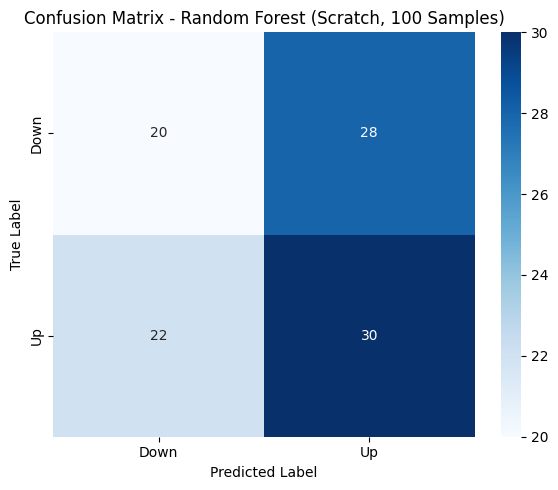

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test[:100], y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix - Random Forest (Scratch, 100 Samples)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


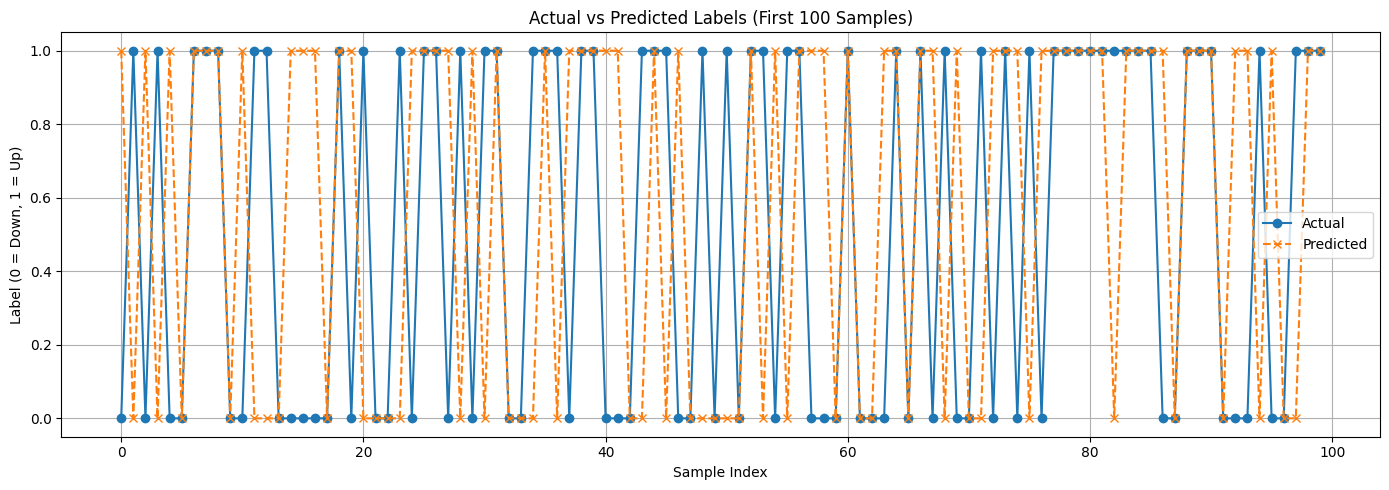

In [5]:
# Line plot of first 100 predictions vs actuals
plt.figure(figsize=(14, 5))
plt.plot(y_test[:100], label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Labels (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Label (0 = Down, 1 = Up)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
